In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from operator import itemgetter
import lmfit
from scipy import signal
from scipy import fftpack
from skimage import util
import operator
from numpy import NaN, Inf, arange, isscalar, asarray, array
import pylab
import inspect

run = ['001','002','003','004','005','006','007','008','009','010',
        '015','020','025','030','035','040','045','050','055','060',
        '065','070','075','080','085','090','095','100','105','110',
        '115','120','125','130','135','140','145','150','155','160',
        '165','170','175','180','185','190']

##############################################################################################################
###############################################    FUNCTIONS     #############################################
##############################################################################################################


#############################################    PEAK DETECTOR     ###########################################

def peakdet(v, delta, x = None):
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

#############################################    FITTING MODEL     ###########################################

def model(t, decay):  # , omega, resid):
    return np.exp(-t/decay)  # * np.cos(omega * t) + resid
gmodel = lmfit.Model(model)

#############################################    DIAGNOSTIC TOOL     ###########################################

def diag_w7x(filename, minlim=None, maxlim=None, spectrogram=False, plot=False, my_data=None, k=None, Lx=None, nkx0=None):
    
    kx_minimum = 2*np.pi/Lx
    kx_ind = np.linspace((kx_minimum), (kx_minimum)*((nkx0//2)-1), (nkx0//2)-1)
    kx  = kx_ind[0:10]
    for s in range(0, 36):
        if s % 2 == 0:
            s = 14+(s*5)
        else:
            s = 19+((s-1)*5)
        kx = np.append(kx, kx_ind[s])
    kx_ind = kx
    
    if maxlim is not None and minlim is None:
        nummy = run[0:maxlim]
        if k is not None:
            kx = kx_ind[k:(maxlim+k)]
        else:
            kx = kx_ind[0:maxlim]
    elif minlim is not None and maxlim is None:
        nummy = run[minlim:len(run)]
        kx = kx_ind[minlim:len(run)]
    elif minlim is not None and maxlim is not None:
        nummy = run[minlim:maxlim]
        if k is not None:
            kx = kx_ind[(k+minlim):(maxlim+k)]
        else:
            kx = kx_ind[minlim:maxlim]
    if minlim is None and maxlim is None:
        nummy = run
        kx = kx_ind
    
    dataset = [('./{0}/GAMDIAGions_0{1}.dat'.format(filename, index), index) for index in nummy]     
    datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array

    if plot == True and type(my_data) == type(None):
        plt.figure(figsize=(13, 6.5))
        plt.axhline(y=0, color='black', linestyle='dashed')
        plt.title("{0}".format(filename), fontsize=30)
        #plt.xscale('log')
        plt.xlabel('Time ($a / v_{ti}$)',fontsize=19)
        plt.ylabel('$\phi (t) / \phi (0)$',fontsize=19)
    
    if type(my_data) == type(None):
        integ = []
        rmsvl = []
        decay = []
        osrat = []
        pekti = []
    else:
        integ = my_data[0, :].tolist()
        rmsvl = my_data[1, :].tolist()
        decay = my_data[2, :].tolist()
        osrat = my_data[3, :].tolist()
        pekti = my_data[10, :].tolist()
    n = 0
    for data, label in datalist:
        #plt.figure(figsize=(13, 6.5))
        #plt.axhline(y=0, color='black', linestyle='dashed')
        #plt.title('W7-X Standard Config. s06', fontsize=30)
        ##plt.xscale('log')
        #plt.xlabel('Time ($a / v_{ti}$)',fontsize=19)
        #plt.ylabel('$\phi (t) / \phi (0)$',fontsize=19)
        #plt.ylim([-0.3, 1.6])
        #plt.xlim([0, 500])
        E = (data[:,1]*(1/data[0, 1]))
        t = data[:,0]
        
        if plot == True:
            plt.plot(t, E, label='{0}'.format(label))
            #plt.text(350, 0.5, 'kx: {0}'.format(round(kx_ind[0+n], 4)), fontsize=14)
            if len(nummy) > 1100:
                plt.legend(kx, title='$k_{x}$', fontsize=14)
                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        intefield = np.trapz(E, t)
        integ.append(intefield)
        rms = np.sqrt(np.mean(E**2))
        rmsvl.append(rms)
        
        result, OS, TP = nucleus_w7x(E, t, label, diag=False)   
        
        decay.append(result.best_values.get('decay'))
        osrat.append(OS)
        pekti.append(TP)
        #plt.savefig('{0}.png'.format(label), format='png', dpi=250)
        n = n+1
        
    if type(my_data) != type(None):
        plt.show()
    
        if spectrogram == True:
            ########  SPECTROGRAM
            f_s = len(data[:, 0]) / data[-1, 0]
            E = (data[:,1]*(1/data[0, 1]))
            M = 1024
            slices = util.view_as_windows(E, window_shape=(M,), step=2)
            win = np.hanning(M + 1)[:-1]
            slices = slices * win
            slices = slices.T
            spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
            spectrum = np.abs(spectrum)
            S = np.abs(spectrum)
            S = 20 * np.log10(S / np.max(S))
            plt.figure()
            plt.imshow(S, origin='lower', cmap='viridis')
            plt.title(str(label), fontsize=30)
            plt.axis('tight')
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time ($a / v_{ti}$)')
            #plt.ylim([0, 0.3])

    f_s = len(data[:, 0]) / data[-1, 0]
    my_data = np.array([integ, rmsvl, decay, osrat, pekti])
    return kx, my_data, E, t, f_s, label

#############################################    DIAGNOSTIC PLOTTER     ###########################################

def retrieve_name(var):
        """
        Gets the name of var. Does it from the out most frame inner-wards.
        :param var: variable to get name from.
        :return: string
        """
        for fi in reversed(inspect.stack()):
            names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
            if len(names) > 0:
                return names[0]

def diag_plotter(kx, my_data, alldata=False, fig=True):
    
    integ = my_data[0, :]
    rmsvl = my_data[1, :]
    decay = my_data[2, :]
    osrat = my_data[3, :]
    pekti = my_data[4, :]
    
    if fig == True:
        fig = plt.figure(figsize=(30, 20))
    else:
        fig = fig
        
    ax1 = fig.add_subplot(231)
    ax2 = fig.add_subplot(232)
    ax3 = fig.add_subplot(233)
    ax4 = fig.add_subplot(234)
    ax5 = fig.add_subplot(235)

    ########  top
    ax1.plot(kx, integ)
    ax2.plot(kx, rmsvl)
    ax3.plot(kx, decay)
    
    #ax1.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax2.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax3.set_xlabel('$k_{x} \\rho_{ti}$')

    ax1.title.set_text('Integral')
    ax2.title.set_text('RMS value')
    ax3.title.set_text('Decay length')

    ########  mid
    ax4.plot(kx, osrat)
    ax5.plot(kx, pekti, label='{0}'.format(retrieve_name(my_data)))
    
    #ax4.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax5.set_xlabel('$k_{x} \\rho_{ti}$')
    
    ax4.title.set_text('Overshoot ratio')
    # ax5.title.set_text('')
    ax5.title.set_text('Peak time')
    ax5.legend(loc="upper right")

    if alldata == False:
        fig.show()

    return fig
#############################################    TROUBLESHOOTER     #############################################
def troubleshooter(E, t, f_s, label, spectrogram=False, freq=False):
    
    fig = plt.figure(figsize=(13, 6.5))
    if freq == True:
        X = fftpack.fft(E)
        freqs = fftpack.fftfreq(len(E)) * f_s
        ax1 = fig.add_subplot(211)
        ax1.stem(freqs, np.abs(X))
        ax1.set_xlabel('Frequency in Hertz [Hz]')
        ax1.set_ylabel('Frequency Domain (Spectrum) Magnitude')
        ax1.set_xlim(0, 0.55)  # f_s / 2)
        #ax2.set_ylim(-2, 2)
        ax2.set_xlim(0, 500)
        
    
    maxtab, mintab, OS, TP, a, e, f = nucleus_w7x(E, t, label, diag=True)
    
    n = ['a', 'e', 'f']
    x = np.array([a, e, f])[:,1]
    y = np.array([a, e, f])[:,0]
    
    ax2 = fig.add_subplot(111)
    ax2.plot(t, E, label='{0}'.format(label))
    ax2.axhline(y=0, color='black', linestyle='dashed')
    ax2.scatter(y,x, color='blue')
    for r, txt in enumerate(n):
        ax2.annotate(txt, (y[r], x[r]))
    ax2.scatter(e[0], e[1], color='green')
    ax2.scatter(maxtab[:, 0], maxtab[:, 1], color='red')
    ax2.scatter(mintab[:, 0], mintab[:, 1], color='blue')
    #ax2.set_xlim(-10, 100)
    print('Overshoot ratio (OS): ' + str(OS))
    print('Peak time (TP): ' + str(TP))
    fig.show()
    
    if spectrogram == True:
            ########  SPECTROGRAM
            M = 1024
            slices = util.view_as_windows(E, window_shape=(M,), step=2)
            win = np.hanning(M + 1)[:-1]
            slices = slices * win
            slices = slices.T
            spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
            spectrum = np.abs(spectrum)
            S = np.abs(spectrum)
            S = 20 * np.log10(S / np.max(S))
            plt.figure(figsize=(13, 6.5))
            plt.imshow(S, origin='lower', cmap='viridis')
            plt.title(str(label), fontsize=30)
            plt.axis('tight')
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time ($a / v_{ti}$)')
            plt.ylim([0, 100])
    plt.show()
    
    return 

def nucleus_w7x(E, t, label, diag=False):
    # Peak detection
    maxtab, mintab = peakdet(E, 0.0001, x=t)
    
    # A fitting to the peak values to get the decay coefficient:
    result = gmodel.fit(E[:150], t=t[:150], decay=10, nan_policy='propagate')
        
    # Maxpeaks
    a = maxtab[0, :]  # Initial point

    min_index, min_value = min(enumerate(mintab[:, 1]), key=operator.itemgetter(1))  
    f = mintab[min_index, :]  # This determines the minimum peak
    
    if np.shape(mintab) != (1, 2):
        e = mintab[1, :]
    else:
        e = f
        
    TP = e[0]                                          # Peak time
    OS = np.abs(e[1] / a[1])                           # Overshoot ratio
            
    if diag == True:
        print('Diag mode on')
        
        return maxtab, mintab, OS, TP, a, e, f
    else:

        return result, OS, TP

In [ ]:
kx_100, my_data_100, E, t, f_s, label = diag_w7x('PEST_vs_BOOZER/w7x_hiota_s05_1-10-190_BOOZER', maxlim=46, plot=True, Lx=665.979, nkx0=384)
plt.figure(figsize=(13, 6.5))
plt.title("$\\tau_{ZF}$ vs integration range", fontsize=20)
for n in range(len(E)):
    intefield = np.trapz(E[:n], t[:n])
    plt.scatter(t[n], intefield)
plt.axhline(y=0, color='black', linestyle='dashed')
plt.show()

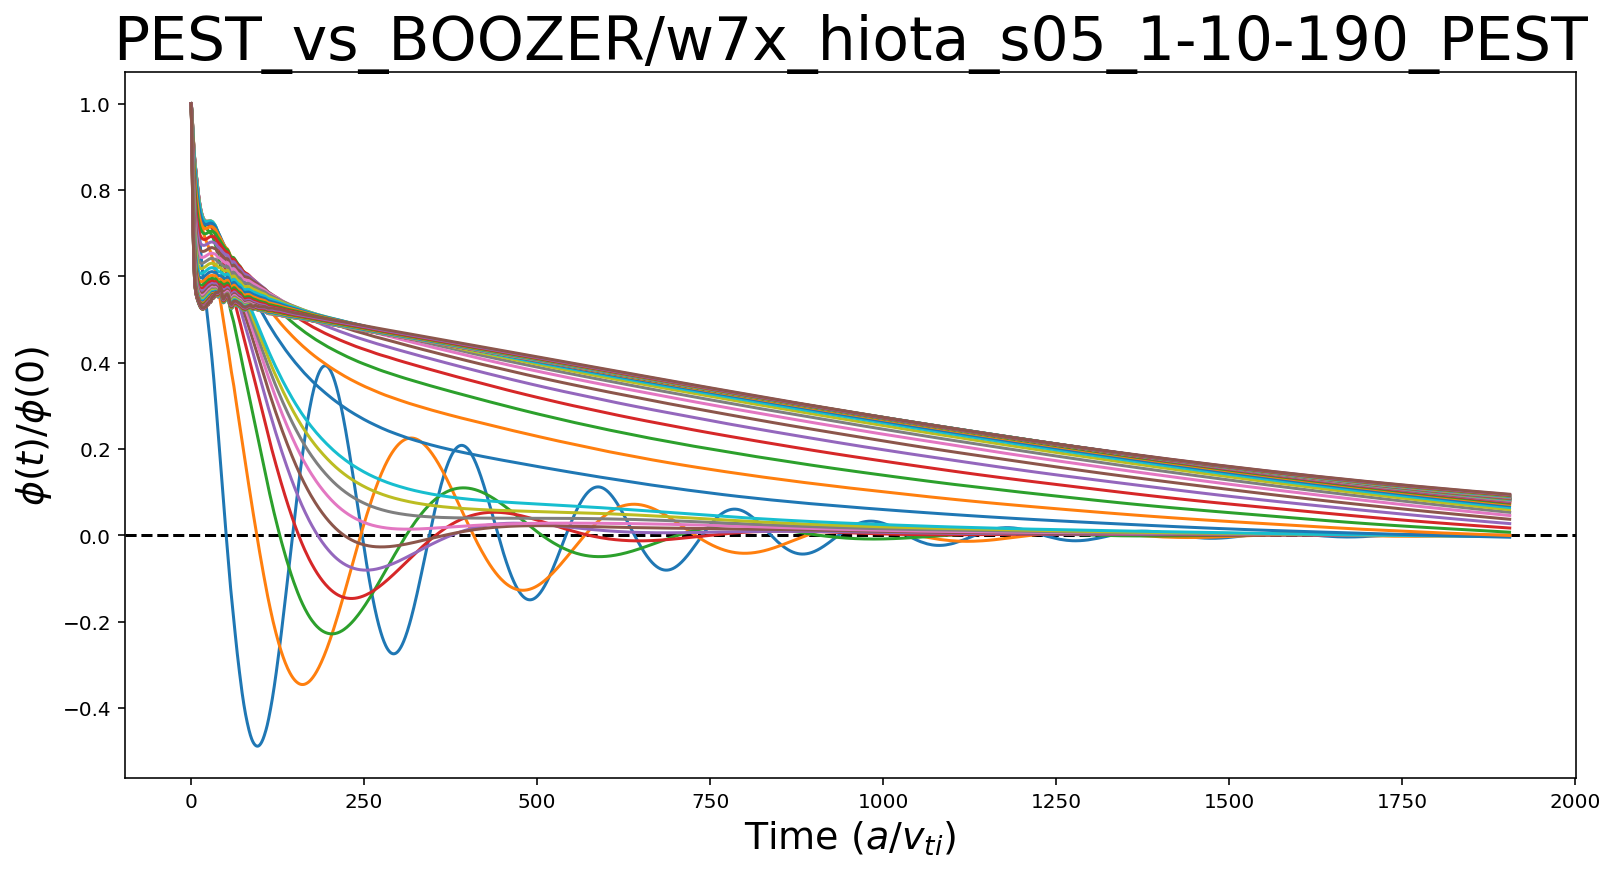

In [2]:
kx_p, my_data_p, E_p, t_p, f_s_p, label_p = diag_w7x('PEST_vs_BOOZER/w7x_hiota_s05_1-10-190_PEST', maxlim=46, plot=True, Lx=665.979, nkx0=384)
#troubleshooter(E, t, f_s, label)
#fig = diag_plotter(kx_100, my_data_100, alldata=False, fig=True)

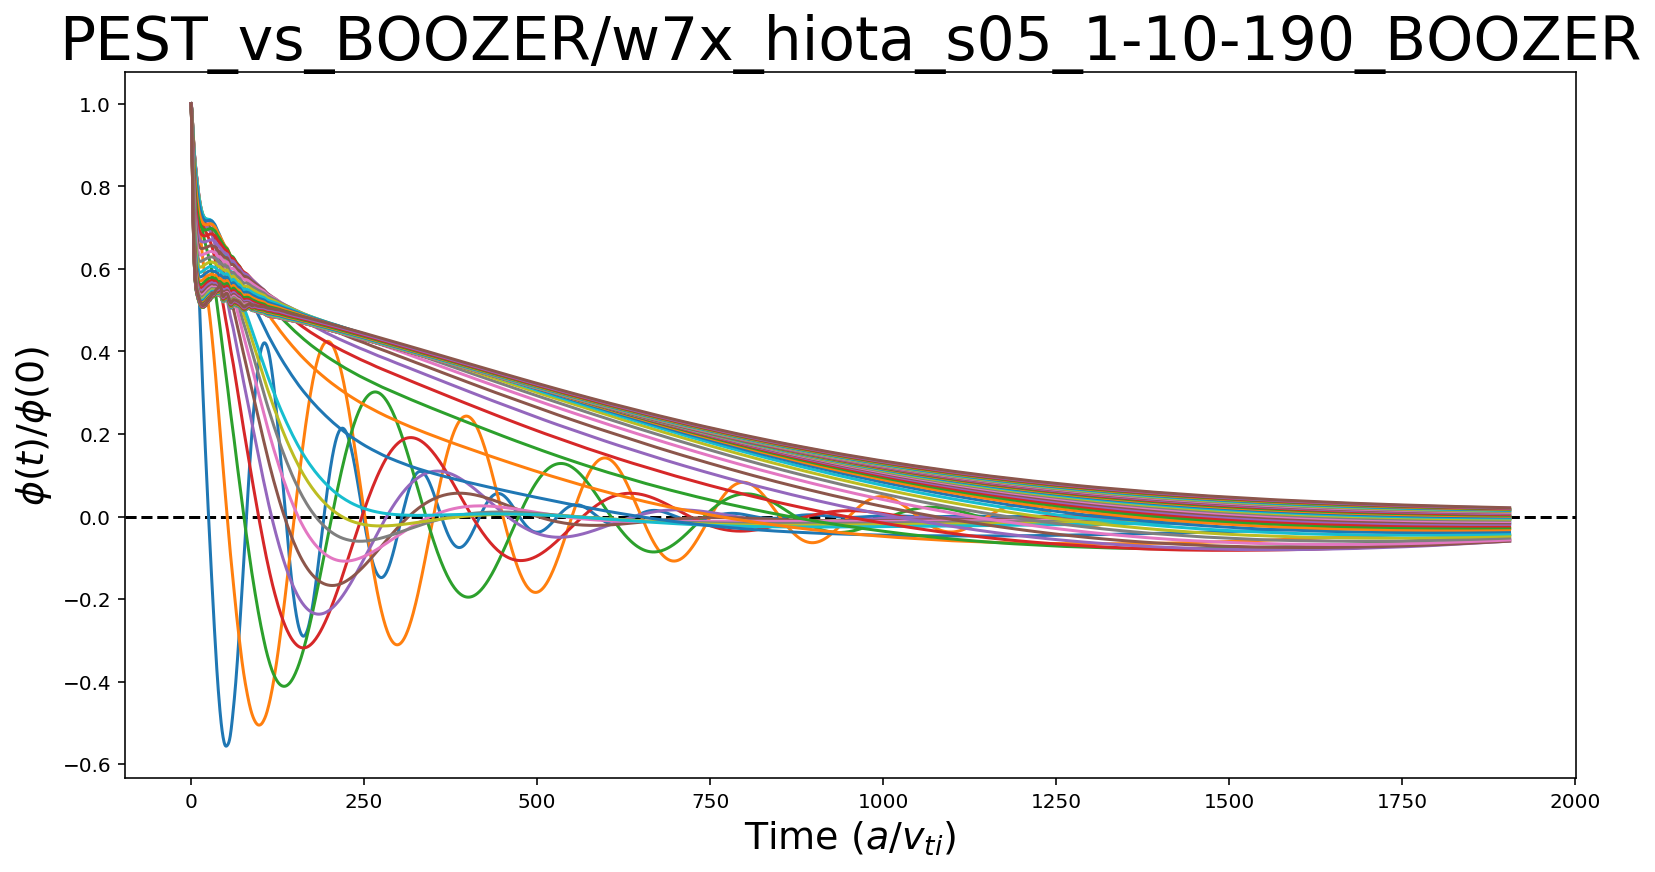

In [4]:
kx_b, my_data_b, E_b, t_b, f_s_b, label_b = diag_w7x('PEST_vs_BOOZER/w7x_hiota_s05_1-10-190_BOOZER', maxlim=46, plot=True, Lx=665.979, nkx0=384)
#troubleshooter(E, t, f_s, label)
#fig = diag_plotter(kx_100, my_data_100, alldata=False, fig=True)

my_data_p
my_data_b


/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


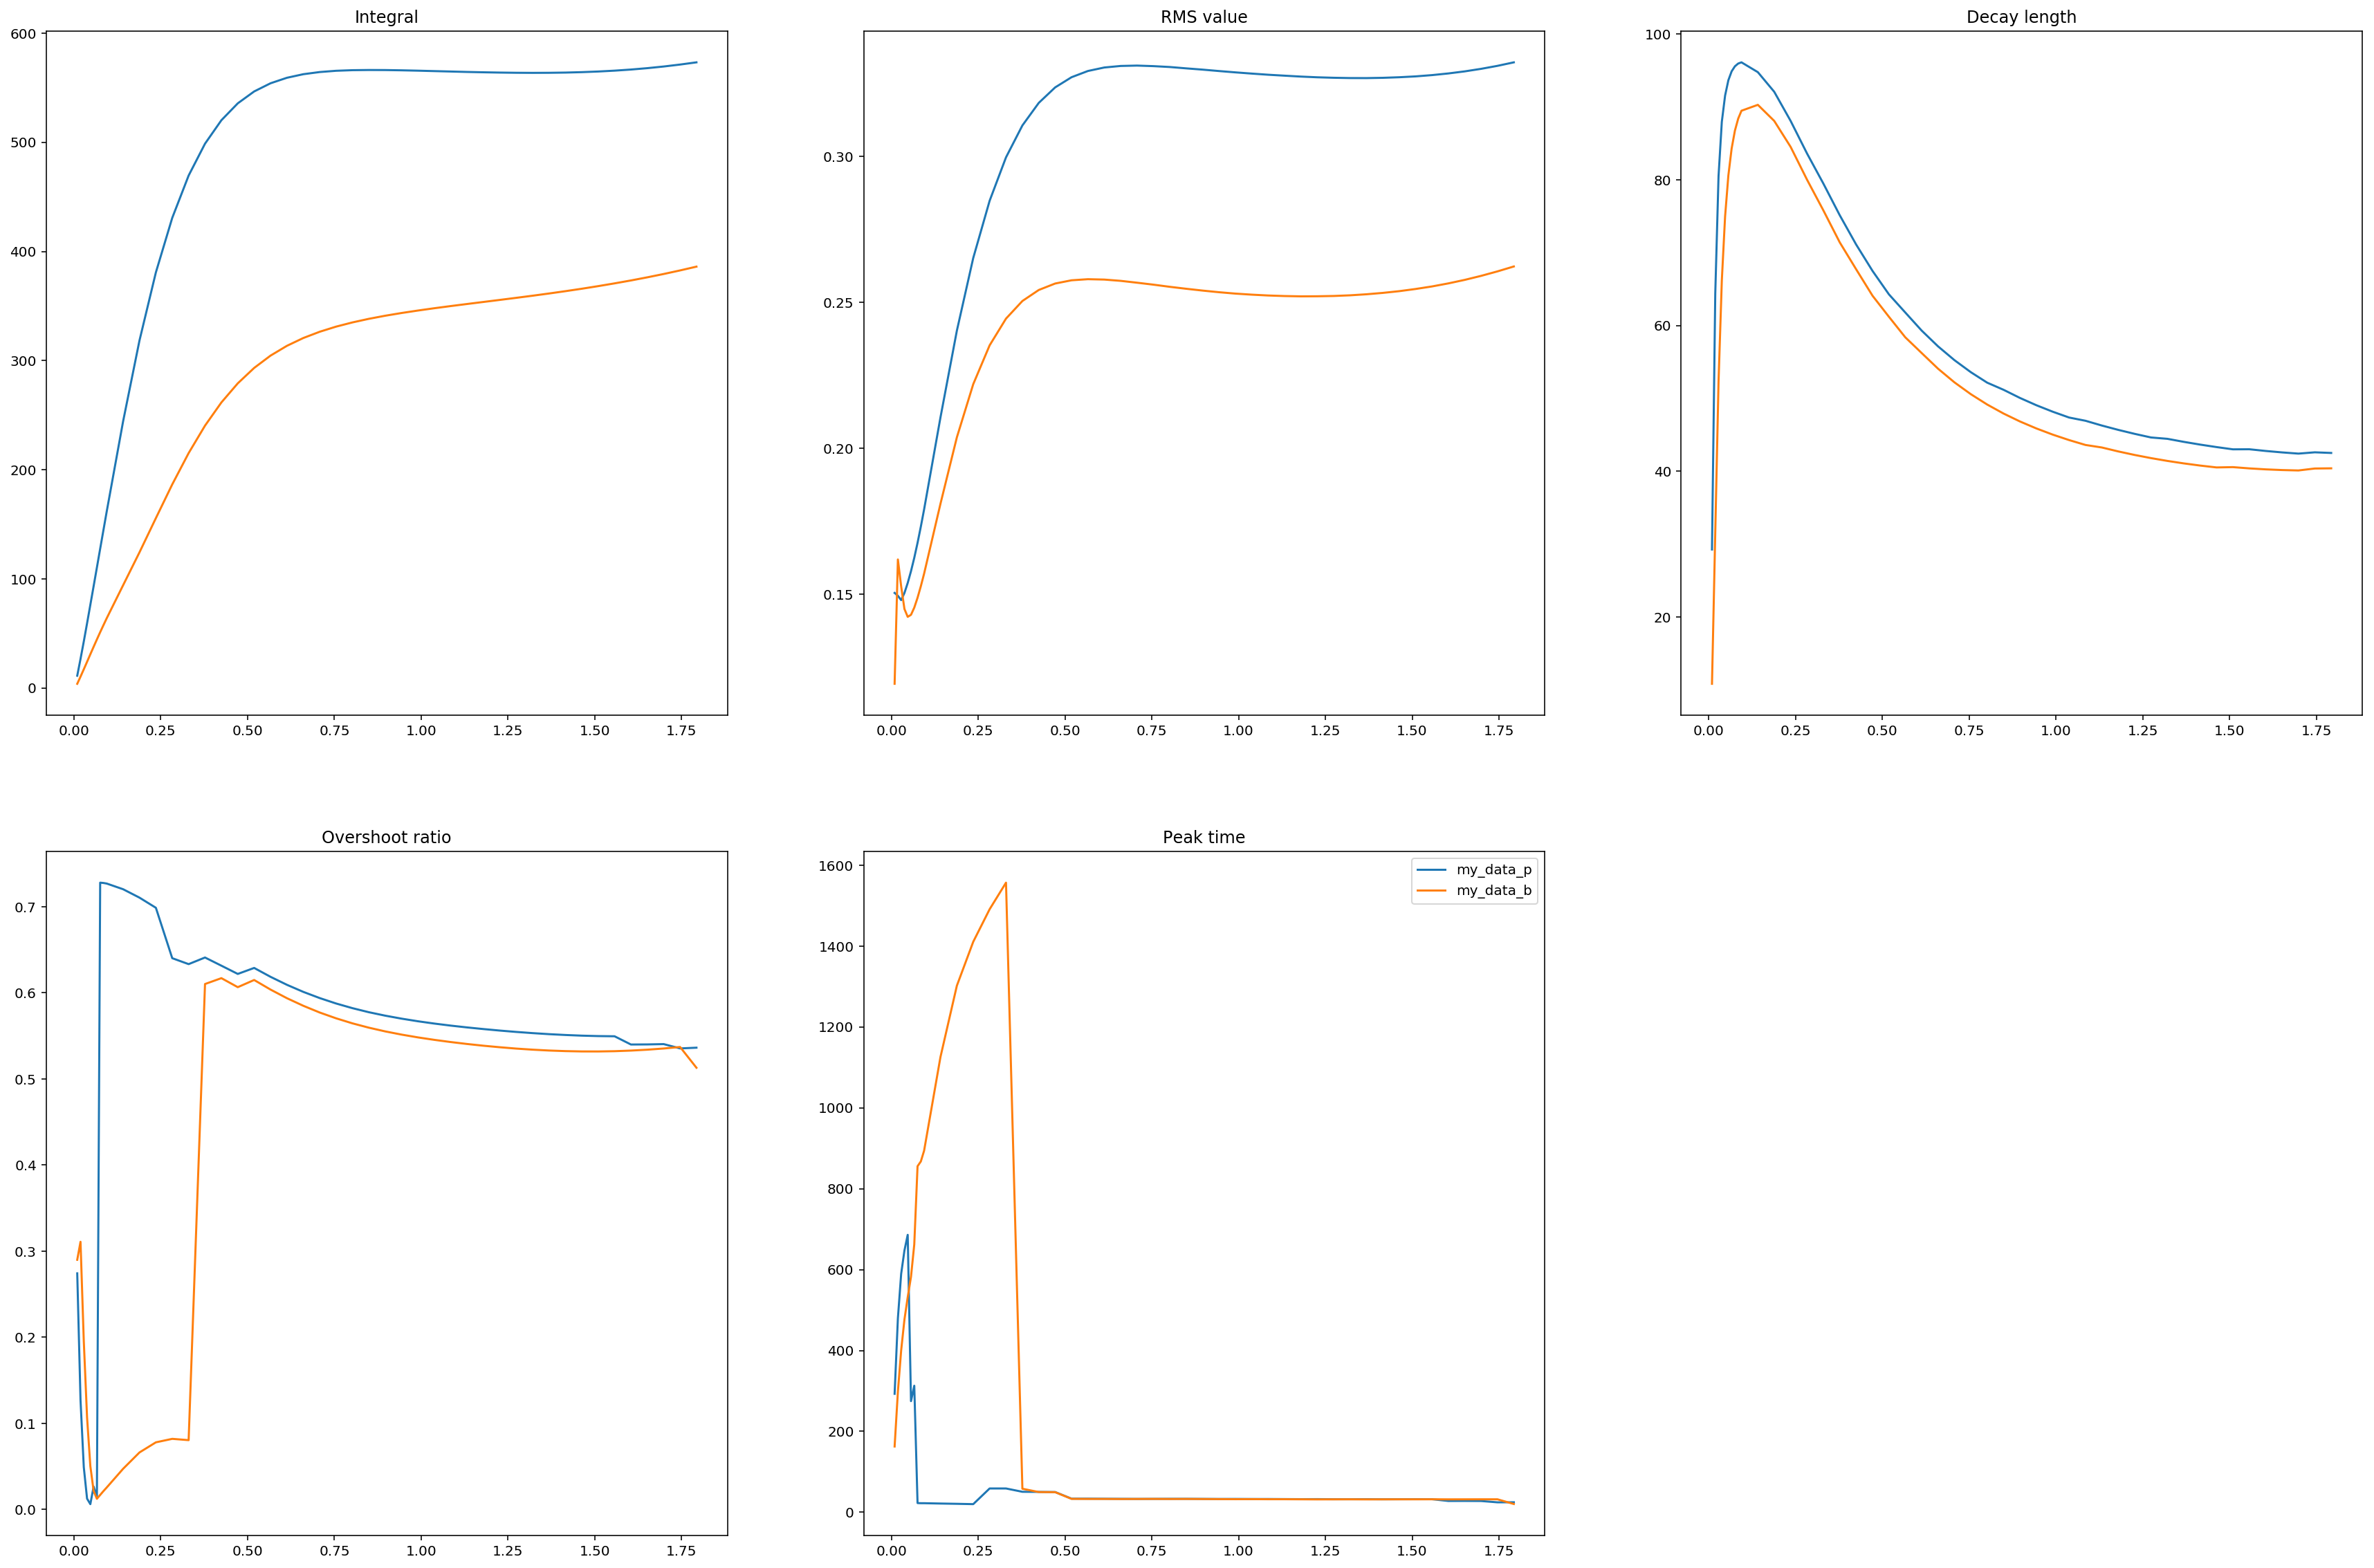

In [5]:
kekdata = my_data_p, my_data_b
kx = kx_p, kx_b
for d in range(0, 2):
    if retrieve_name(kekdata[d]) == retrieve_name(my_data_p):
        fig = diag_plotter(kx[d], kekdata[d], alldata=True, fig=True)
    else:
        fig = diag_plotter(kx[d], kekdata[d], alldata=True, fig=fig)
    print(retrieve_name(kekdata[d]))
plt.show()